I computed realizations of multiple HODs for a few statistics in the darksky boxes. This notebook is gonna combine them into a jackknife covmat. It'll also add some estimate of the shape noise contribution. 

In [60]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [61]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)

In [62]:
import numpy as np
from glob import glob
from os import path
from copy import deepcopy

In [63]:
#shape_noise_covmat = np.load('/u/ki/swmclau2/Git/pearce/bin/covmat/shape_noise.npy')
shape_noise_covmat = np.load('./Hankel_transform/shape_noise.npy')

In [64]:
print np.sqrt(np.diag(shape_noise_covmat))

[ 1.0263207   0.98494148  0.90722623  0.69274081  0.57677226  0.45103709
  0.32990732  0.23736836  0.17742547  0.13398334  0.10010477  0.07595037
  0.05802125  0.04515957  0.03575584  0.02910926  0.02429026  0.02063339]


In [65]:
darksky_h = 0.7036893781978598

In [66]:
output_dir = '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat_v3/'

In [67]:
outputs = sorted(glob(path.join(output_dir, 'wp_ds_cic_darksky_obs_???.npy')))
print len(outputs)

511


In [68]:
N = len(outputs) # Should be 512, but a few may not have finished. Should make sure that those get reestarted, but likely not super important
all_outputs = np.zeros((N, 5,  2*18 + 14)) # num bins and num HODs 

In [69]:
2*18+14

50

In [70]:
for i,output_file in enumerate(outputs):
    if i == 0:
        continue
    output = np.load(output_file)
    all_outputs[i] = output#.mean(axis = 0)


In [71]:
all_outputs.shape

(511, 5, 50)

In [72]:
# undo a little h error of mine. 
# WARNING i've since corrected this so it will no longer be necessary with new computations
#all_outputs[:, :, 18:36]*=darksky_h**2

In [73]:
# I'm waiting for my v3 calculation to finish. In the interim i will just divide out the h scaling of wp (ds is already corrected)
#all_outputs[:, :, :18]*=darksky_h**2

In [74]:
rp_bins = np.logspace(-1.0, 1.6, 19)
cic_bins = np.round(np.r_[np.linspace(1, 9, 8), np.round(np.logspace(1,2, 7))] )

In [75]:
cic_bins

array([   1.,    2.,    3.,    4.,    6.,    7.,    8.,    9.,   10.,
         15.,   22.,   32.,   46.,   68.,  100.])

In [76]:
rp_points = (rp_bins[1:]+rp_bins[:-1])/2.0
cic_points = (cic_bins[1:]+cic_bins[:-1])/2.0

In [77]:
all_outputs[:,4,:18]

array([[    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [ 2591.36620248,  2134.02105232,  1698.89914486, ...,
           14.58289426,     8.40746167,     4.2347895 ],
       [ 2669.1210813 ,  2116.12086265,  1673.42274317, ...,
           14.01556299,     8.01812491,     3.81004993],
       ..., 
       [ 2716.06636378,  2218.24072652,  1767.67859268, ...,
           14.25390728,     8.37935971,     3.98869766],
       [ 2713.24216414,  2204.11512046,  1744.37597399, ...,
           14.22254178,     8.20788337,     3.79906551],
       [ 2683.54677227,  2213.31193545,  1768.53466689, ...,
           14.46024784,     8.42318952,     4.24963272]])

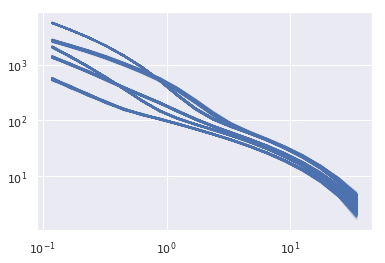

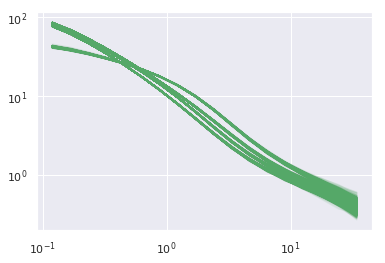

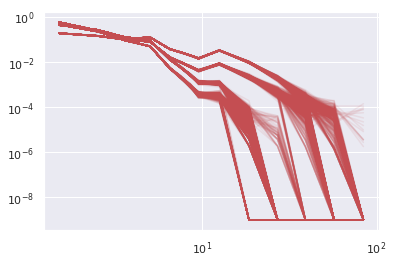

In [78]:
for hod_idx in xrange(5):
    color = 'b' 
    plt.plot(rp_points, (all_outputs[:,hod_idx, :18]).T, alpha = 0.1, color = color)
    plt.loglog();
plt.show();
for hod_idx in xrange(4):
    plt.plot(rp_points, (all_outputs[:,hod_idx, 18:36]).T, alpha = 0.1, color = 'g')
    plt.loglog();
plt.show();

for hod_idx in xrange(4):
    plt.plot(cic_points, all_outputs[:, hod_idx, 36:].T, alpha = 0.1, color = 'r')
    plt.loglog();
plt.show();

In [79]:
nonzero_idxs =np.all(np.all(all_outputs!=0.0, axis = 2), axis=1)

#mean = all_outputs.mean(axis = 0)

In [80]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

In [81]:
np.zeros(len(cic_bins)-1)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [82]:
# from my HOD mock on MDPL2
# for the time being, a place holder with the right h scaling 
import numpy as np
wp_hod = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/HOD5mock_wp.npy')
ds_hod = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/HOD5mock_ds.npy')

planck_y = np.r_[wp_hod, ds_hod, np.zeros(len(cic_bins)-1)]

In [83]:
# from my HOD mock on MDPL2
# for the time being, a place holder with the right h scaling 
wp_hod2 = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/HOD4mock_wp.npy')
ds_hod2 = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/HOD4mock_ds.npy')

#planck_y = np.r_[wp_hod, ds_hod, np.zeros(len(cic_bins)-1)]

In [84]:
planck_y.shape

(50,)

In [85]:
mean = all_outputs[nonzero_idxs].mean(axis = 0)
R =(all_outputs[nonzero_idxs] - mean)

corr = np.zeros((R.shape[2], R.shape[2]))
yerr_ratio = np.zeros((R.shape[2]))
for i in xrange(R.shape[1]):
    c= R[:,i].T.dot(R[:,i])/(N-1)
    corr += cov_to_corr(c)
    yerr_ratio += np.sqrt(np.diag(c))/mean[i]
    
    
corr/= (mean.shape[0])#*(N-1)
yerr_ratio/=(mean.shape[0])

In [86]:
print yerr_ratio

[  1.73517133e-02   1.62779249e-02   1.57696192e-02   1.54572417e-02
   1.54423081e-02   1.54665305e-02   1.60352856e-02   1.67981346e-02
   1.67574624e-02   1.60034903e-02   1.49434657e-02   1.41145762e-02
   1.48480703e-02   1.75100723e-02   2.11253346e-02   2.80863508e-02
   4.18804132e-02   7.67915990e-02   8.75446357e-03   6.93531440e-03
   5.42722479e-03   4.80686585e-03   4.23634729e-03   4.26668162e-03
   4.92254064e-03   6.21637272e-03   8.10324579e-03   1.05117969e-02
   1.28896167e-02   1.52736711e-02   1.81751363e-02   2.20079366e-02
   2.86173341e-02   3.86936549e-02   5.30462621e-02   7.91292015e-02
   7.28443782e-03   8.03274532e-03   9.60336445e-03   1.05871968e-02
   2.20847526e-02   3.26827948e-02   4.34900656e-02   6.20094397e-02
   8.00589931e-02   3.96399841e-01   2.82988209e+00   2.45277474e-01
   8.51031300e-01   5.01174866e+00]


In [87]:
corr

array([[ 1.        ,  0.31563244,  0.33186789, ...,  0.10989164,
         0.09606404,  0.0721051 ],
       [ 0.31563244,  1.        ,  0.39258173, ...,  0.12981055,
         0.11054508,  0.07814695],
       [ 0.33186789,  0.39258173,  1.        , ...,  0.15757212,
         0.10609687,  0.08380549],
       ..., 
       [ 0.10989164,  0.12981055,  0.15757212, ...,  1.        ,
         0.52051938,  0.42191267],
       [ 0.09606404,  0.11054508,  0.10609687, ...,  0.52051938,
         1.        ,  0.45650185],
       [ 0.0721051 ,  0.07814695,  0.08380549, ...,  0.42191267,
         0.45650185,  1.        ]])

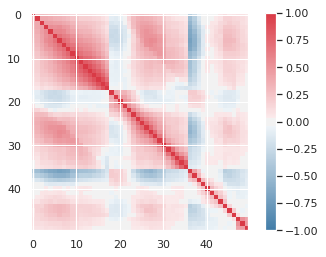

In [88]:
im = plt.imshow(corr, cmap = cmap, vmin=-1)
plt.colorbar(im)

In [89]:
yerr = yerr_ratio*planck_y
cov = corr*np.outer(yerr, yerr)

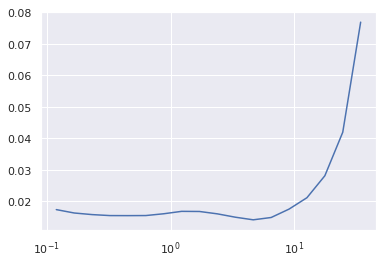

In [90]:
plt.plot(rp_points, np.sqrt(np.diag(cov))[:18]/wp_hod)
plt.xscale('log')

In [91]:
cov.shape

(50, 50)

In [92]:
np.min(cov)

-1.5198306172834515

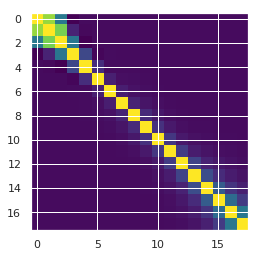

In [93]:
plt.imshow(cov_to_corr(shape_noise_covmat), cmap = 'viridis')

In [94]:
print(cov_to_corr(shape_noise_covmat))[:5, :5]

[[  1.00000000e+00   8.42406214e-01   3.86208997e-01  -2.93016279e-02
   -1.97547565e-04]
 [  8.42406214e-01   1.00000000e+00   7.88979947e-01   7.39946700e-02
   -3.67370677e-03]
 [  3.86208997e-01   7.88979947e-01   1.00000000e+00   3.73641155e-01
   -2.94861577e-02]
 [ -2.93016279e-02   7.39946700e-02   3.73641155e-01   1.00000000e+00
    1.92649413e-01]
 [ -1.97547565e-04  -3.67370677e-03  -2.94861577e-02   1.92649413e-01
    1.00000000e+00]]


In [95]:
full_cov = deepcopy(cov)

full_cov[18:36][:, 18:36] = full_cov[18:36][:, 18:36]+ shape_noise_covmat

In [96]:
corr = cov_to_corr(cov)
full_corr = cov_to_corr(full_cov)

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


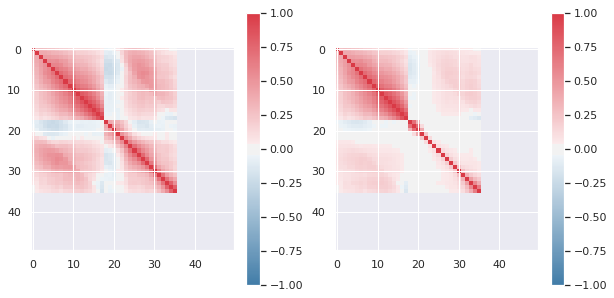

In [97]:
fig = plt.figure(figsize = (10, 5))
plt.subplot(121)
im = plt.imshow(corr, cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(122)
im = plt.imshow(full_corr, cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

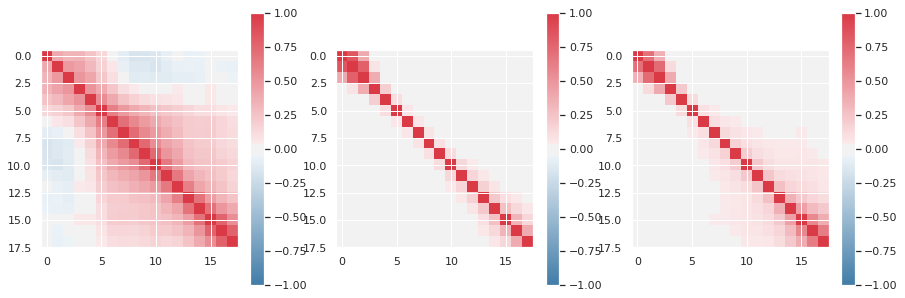

In [98]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(131)
im = plt.imshow(corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(132)
im = plt.imshow(cov_to_corr(shape_noise_covmat), cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(133)
im = plt.imshow(full_corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

In [99]:
np.sqrt(np.diag(full_corr)[18:36])

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.])

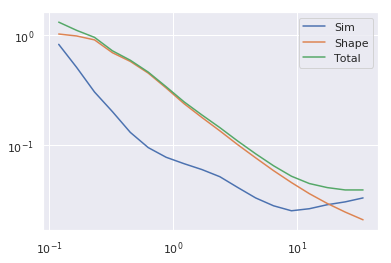

In [100]:
plt.plot(rp_points, np.sqrt(np.diag(cov)[18:36]), label = 'Sim')
plt.plot(rp_points,np.sqrt(np.diag(shape_noise_covmat)), label = 'Shape')

plt.plot(rp_points,np.sqrt(np.diag(full_cov)[18:36]), label = 'Total')
#plt.xscale('log')
plt.loglog();
plt.legend(loc = 'best')

In [101]:
print full_corr[30:30+5][:, 30:30+5]

[[ 1.          0.26987367  0.15419281  0.12078679  0.09606168]
 [ 0.26987367  1.          0.34785814  0.21290648  0.15221014]
 [ 0.15419281  0.34785814  1.          0.43961802  0.29074286]
 [ 0.12078679  0.21290648  0.43961802  1.          0.56789007]
 [ 0.09606168  0.15221014  0.29074286  0.56789007  1.        ]]


In [102]:
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/wp_ds_full_covmat_h.npy', full_cov[:36][:, :36])
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/wp_full_covmat_h.npy', full_cov[:18][:, :18])
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/ds_full_covmat_h.npy', full_cov[18:36][:, 18:36])
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/wp_ds_sim_covmat_h.npy', cov[:36][:, :36])

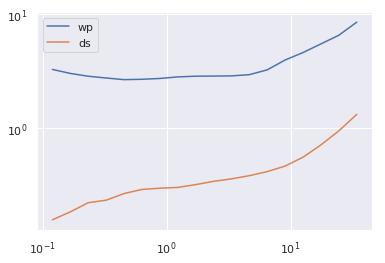

In [103]:
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[:18, :18]) ), label = 'wp')
#plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat) ), label = 'Shape')
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[18:36, 18:36]) ), label = 'ds')

plt.loglog()
plt.legend(loc='best')

In [104]:
print np.sqrt(np.diag(full_cov[:36][:,:36]))

[ 27.29991629  18.06355286  12.24011968   8.46932406   5.87555817
   4.24273496   3.09318005   2.28835828   1.66471649   1.19720076
   0.86121976   0.63305045   0.50022746   0.43748437   0.36462008
   0.31120078   0.26573152   0.24806735   1.31740358   1.10871061
   0.95654433   0.7212308    0.59117272   0.46077343   0.3387444
   0.24669054   0.18709173   0.14339207   0.10807089   0.0826886
   0.06429923   0.05159613   0.04424244   0.04063135   0.0386685
   0.03866788]


In [105]:
print  np.sqrt(np.diag(full_cov[18:36, 18:36]) )

[ 1.31740358  1.10871061  0.95654433  0.7212308   0.59117272  0.46077343
  0.3387444   0.24669054  0.18709173  0.14339207  0.10807089  0.0826886
  0.06429923  0.05159613  0.04424244  0.04063135  0.0386685   0.03866788]


In [106]:
#emu covs
emu_cov_fnames = ['/home/users/swmclau2/Git/pearce/bin/optimization/wp_hod_emu_cov_lpw.npy',
                  '/home/users/swmclau2/Git/pearce/bin/optimization/ds_hod_emu_cov_lpw.npy']

In [107]:
emu_cov = np.zeros_like(full_cov[:36][:, :36])

for i, fname in enumerate(emu_cov_fnames):
    
    emu_cov[i*18:(i+1)*18][:, i*18:(i+1)*18] = np.load(fname)

In [108]:
emu_corr = cov_to_corr(emu_cov)

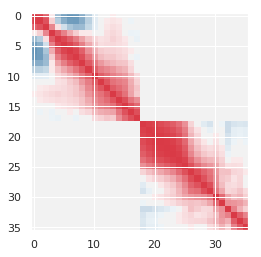

In [109]:
plt.imshow(emu_corr, cmap = cmap, vmin = -1)

In [110]:
full_emu_cov = full_cov[:36][:, :36] + emu_cov

In [111]:
print np.sqrt(np.diag(full_emu_cov[:36][:,:36]))

[  1.15409665e+02   5.91729302e+01   2.46857692e+01   1.53391915e+01
   1.24892469e+01   9.42901782e+00   6.21090069e+00   3.81019436e+00
   2.38238107e+00   1.58272218e+00   1.05092811e+00   7.94767725e-01
   6.75370027e-01   5.64807615e-01   4.53442042e-01   4.05593347e-01
   3.46978230e-01   3.29792111e-01   1.94641646e+00   1.69954176e+00
   1.42664548e+00   1.09715168e+00   8.47982210e-01   6.08870860e-01
   4.17815459e-01   2.83998892e-01   2.06405395e-01   1.55566058e-01
   1.15259479e-01   8.76590441e-02   6.87374001e-02   5.52525455e-02
   4.84300126e-02   4.53017322e-02   4.47472267e-02   4.70238038e-02]


In [112]:
full_emu_corr = cov_to_corr(full_emu_cov)

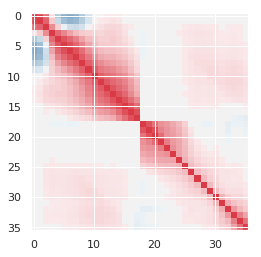

In [113]:
plt.imshow(full_emu_corr, cmap = cmap, vmin = -1)

In [114]:
mean[:,:18].mean(axis=0)

array([ 2444.09011394,  1830.48219075,  1349.61611574,   968.11865876,
         673.10681464,   457.91072134,   302.88269721,   195.30568208,
         127.4544226 ,    87.1220033 ,    63.69149303,    48.24394134,
          36.2133878 ,    26.25057543,    18.06682571,    11.56071968,
           6.65874113,     3.27263287])

In [115]:
print np.sqrt(np.diag(full_cov[:18, :18]) )/wp_hod#mean[:-1, :18].mean(axis=0)
print np.sqrt(np.diag(emu_cov[:18, :18]) )/wp_hod#mean[:-1, :18].mean(axis=0)

[ 0.01735171  0.01627792  0.01576962  0.01545724  0.01544231  0.01546653
  0.01603529  0.01679813  0.01675746  0.01600349  0.01494347  0.01411458
  0.01484807  0.01751007  0.02112533  0.02808635  0.04188041  0.0767916 ]
[ 0.07127211  0.05077823  0.02761912  0.02334122  0.02896531  0.03069638
  0.02792073  0.02236322  0.01715539  0.01383848  0.0104506   0.01071382
  0.01346876  0.01429804  0.01561767  0.02347582  0.03516399  0.06727165]


In [116]:
np.sqrt(np.diag(full_emu_cov[:18, :18]) )/mean[:-1, :18].mean(axis=0)

array([ 0.0483756 ,  0.033855  ,  0.01965204,  0.01754742,  0.0212843 ,
        0.02459232,  0.02547946,  0.02453519,  0.02268666,  0.02064664,
        0.01787042,  0.01755592,  0.01983184,  0.02289117,  0.02672289,
        0.03740501,  0.05571321,  0.1083461 ])

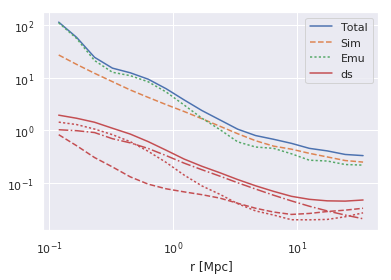

In [117]:
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[:18, :18]) ), label = 'Total')
plt.plot(rp_points, np.sqrt(np.diag(cov[:18, :18]) ), ls = '--', label = 'Sim')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[:18, :18]) ), ls = ':', label = 'Emu')


plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'ds', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'r', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'r',  ls = '-.')

#plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

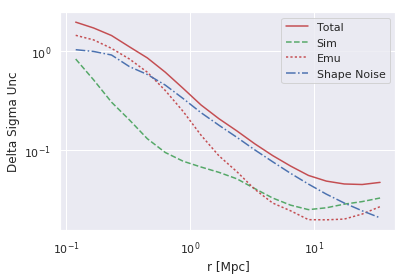

In [118]:
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'Total', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'g', label = 'Sim', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':', label = 'Emu')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'b', label = 'Shape Noise',ls = '-.')

plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

In [119]:
0.7**2

0.48999999999999994